In [1]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

## Internal Links ##
- Vaccinations, Cases, Deaths [casevax_df](#build_casevax).

- Statewide Stats [us_df](#build_us_df)

### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"

Loading BokehJS ...

In [3]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

In [4]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
use_cached_files = True

confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"

county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"

#CDC Data: https://catalog.data.gov/dataset/covid-19-vaccinations-in-the-united-statescounty

#//***********************************************************************************************
#//*** California COVID Data website:
#//**************************************
#//*** https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state
#//***********************************************************************************************

#//*** Download California Current COVID Demograohic Data
if not use_cached_files:
    try:
        response = requests.get("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
        if response.ok:
            print("US Confirmed Data Downloaded")
            f = open(confirmed_data_filename, "w")
            f.write(response.text)
            f.close()
            print("US Confirmed Data Written to file.")
    except:
        print("US Confirmed Data: Trouble Downloading From Johns Hopkins Github")

    try:
        response = requests.get("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
        if response.ok:
            print("US Deaths Data Downloaded")
            f = open(death_data_filename, "w")
            f.write(response.text)
            f.close()
            print("US Death Data Written to file.")
    except:
        print("US Death Data: Trouble Downloading From Johns Hopkins Github")
        
    try:
        #response = requests.get("https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD")
        response = requests.get("https://data.cdc.gov/api/views/unsk-b7fc/rows.csv?accessType=DOWNLOAD")
        if response.ok:
            print("Vaccination Data Downloading")
            f = open(vaccine_data_filename, "w")
            f.write(response.text)
            f.close()
            print("US Vaccination Data Written to file.")
    except:
        print("US Vaccine Data: Trouble Downloading From CDC")

    try:
        #//*** CDC Vaccination County Data
        #//*** Source: https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh
        response = requests.get("https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD")
        if response.ok:
            print("County Vaccination Data Downloading")
            #//*** Write CSV File
            f = open(county_vaccine_data_filename.replace(".zip",""), "w")
            f.write(response.text)
            f.close()

            #//*** File > 100 mb
            #//*** read the CSV into a Dataframe and pickle the file with compression
            pd.read_csv(county_vaccine_data_filename.replace(".zip","")).to_pickle(county_vaccine_data_filename)

            #//*** Delete the Original CSV File
            os.remove(county_vaccine_data_filename.replace(".zip",""))

            print("US County Vaccination Data Written to file.")
    except:
        print("US County Vaccine Data: Trouble Downloading From CDC")    


#confirm_df = pd.read_csv(confirmed_data_filename, dtype={"FIPS":np.int32})


In [5]:
if use_cached_files:
    #//*** Load Locally stored data
    attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
    print("Loading Cached: confirm_df")
    attrib_death_df = pd.read_pickle(attrib_death_filename)
    print("Loading Cached: death_df")
    
    print("Load Geo Vaccine Data")
    geo_vax_df = pd.read_pickle(geo_vax_filename)

    print("Load Casevax_df: Combined Case, Death, Vaccination Data ")
    casevax_df = pd.read_pickle(casevax_filename)
    
        
    # Read all dates JSON
    with open(all_dates_filename, "r") as infile:
        all_dates = json.loads(infile.read())['all_dates']
    print("Loading Cached: all_dates")
else:
    print("Re-Building Data...")
    #//**** Load Confirmed Data
    confirm_df = pd.read_csv(confirmed_data_filename)
    confirm_df = confirm_df.dropna(subset=["FIPS"])

    #//**** Load death Data
    death_df = pd.read_csv(death_data_filename)
    death_df = death_df[death_df["Admin2"] != "Unassigned"]
    death_df = death_df.dropna(subset=["FIPS"])

    #//*** Rename Columns to sync dataframes by FIPS/GEOID

    ren_cols = {
        "FIPS" : "GEOID"
    }

    #//*********************************
    #//*** Rename Confirmed Cols
    #//*********************************

    #//*** Get columns
    cols = np.array(confirm_df.columns)

    #//*** Rplace Values
    for find_col,replace_col in ren_cols.items():
        cols = np.where(cols == find_col,replace_col,cols)

    #//*** update columns
    confirm_df.columns = cols

    #//*********************************
    #//*** Rename Death Cols
    #//*********************************
    #//*** Get columns
    cols = np.array(death_df.columns)

    #//*** Replace Values
    for find_col,replace_col in ren_cols.items():
        cols = np.where(cols == find_col,replace_col,cols)

    #//*** update columns
    death_df.columns = cols


    confirm_df["GEOID"] = confirm_df["GEOID"].astype(int)
    death_df["GEOID"] =   death_df["GEOID"].astype(int)

    #//*** US States Only. Lose the Territories
    confirm_df = confirm_df[confirm_df['iso3'] == 'USA']
    death_df = death_df[death_df['iso3'] == 'USA']


    #//*** Get Shape File
    states = gpd.read_file('maps\cb_2018_us_county_20m.shp')

    #//*** Keep the important Columns
    states = states[['STATEFP','GEOID','NAME','geometry']]


    states['GEOID'] = states['GEOID'].astype(int)

    #//*** Merge with Shapes
    confirm_df = states.merge(confirm_df,left_on="GEOID",right_on="GEOID")
    death_df = states.merge(death_df,left_on="GEOID",right_on="GEOID")

    #//*** Remove Extra Columns
    rem_cols = ['iso2','iso3','code3',"Admin2","Country_Region","Lat","Long_","UID"]

    cols = list(confirm_df.columns)

    for col in rem_cols:
        cols.remove(col)

    confirm_df = confirm_df[cols]

    cols = list(death_df.columns)

    for col in rem_cols:
        cols.remove(col)

    death_df = death_df[cols]

    #//*** Convert Cumulative Cases to Daily Cases
    confirm_df[confirm_df.columns[6:]] = confirm_df[confirm_df.columns[6:]].diff(axis = 1, periods = 1)
    death_df[death_df.columns[7:]]     = death_df[death_df.columns[7:]].diff(axis = 1, periods = 1)

    #//*** Convert to 7-day Rolling Mean of New Cases
    confirm_df[confirm_df.columns[6:]] = confirm_df[confirm_df.columns[6:]].rolling(7,axis=1).mean()
    death_df[death_df.columns[7:]] = death_df[death_df.columns[7:]].rolling(7,axis=1).mean()


    #//*** Remove the single na column
    confirm_df = confirm_df.dropna(axis=1)
    death_df = death_df.dropna(axis=1)



    #//**** Merge Population with confirm. Pop_df is first to keep population stats away from the data columns that are added sequentially every day
    confirm_df = confirm_df.merge(death_df[['GEOID','Population']].copy(),left_on="GEOID",right_on="GEOID")

    #//*** Generate population 100k values
    confirm_df['pop_100k'] = confirm_df['Population'] / 100000
    death_df['pop_100k'] = death_df['Population'] / 100000

    #//*** Filter out Hawaii and Alaska
    confirm_df = confirm_df[confirm_df["Province_State"] != "Hawaii"]
    confirm_df = confirm_df[confirm_df["Province_State"] != "Alaska"]

    death_df = death_df[death_df["Province_State"] != "Hawaii"]
    death_df = death_df[death_df["Province_State"] != "Alaska"]
    
    print("Done!")


Loading Cached: confirm_df
Loading Cached: death_df
Load Geo Vaccine Data
Load Casevax_df: Combined Case, Death, Vaccination Data 
Loading Cached: all_dates


<a id="build_us_df"></a> 
### Build State Totals: Vaccination, Confirmed, Death ###

In [91]:
#//******************************
#//**** Build State Vaccine Data
#//******************************
use_cached_files=False
if use_cached_files:
    print("Using Cached Vaccination Data: Skip Processing")
else:
    #//*** read Raw Vaccine csv
    vax_df = pd.read_csv(vaccine_data_filename)

    #//*** Filter Columns to get just the Completed Values
    cols = ['Date','Location']
    filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
    for col in vax_df.columns:
        if 'Complete' in col or 'Dose1' in col:
            skipVal = False
            for val in filter_val:
                if val in col:
                    skipVal = True
                    continue
            if skipVal:
                continue
            cols.append(col)

    #//*** Keep Relevant Data
    vax_df = vax_df[cols]

    #//***************************************
    #//*** Build Vaccine Geographic Data
    #//***************************************

    #//*** Get Shape File
    states = gpd.read_file('maps\cb_2018_us_state_20m.shp')

    #//*** Keep the important Columns
    states = states[['STATEFP','GEOID','NAME','geometry']]

    states['GEOID'] = states['GEOID'].astype(int)
    states['STATEFP'] = states['STATEFP'].astype(int)

    #//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
    #//*** Load DF with States and FIPS values
    state_fips = pd.read_csv("state_fips.csv")
    geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

    #//*** remove States not in continental US
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "AK" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "HI" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "AS" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "GU" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "MP" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "PR" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "VI" ]

    #//*** Merge Geographic Data with Vaccince Data
    geo_vax_df = states.merge(geo_vax_df,left_on="STATEFP",right_on="FIPS")

    #//*** Round the Vaccination Percentages
    geo_vax_df["Series_Complete_Pop_Pct"] = geo_vax_df["Series_Complete_Pop_Pct"].round(1)
    geo_vax_df["Administered_Dose1_Pop_Pct"] = geo_vax_df["Administered_Dose1_Pop_Pct"].round(1)

    geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))
    

    #//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data
    
    #//***Process Deaths
    us_deaths_df = pd.DataFrame()
    
    for group in death_df.groupby('Province_State'):
        loop_stats_df = group[1][group[1].columns[12:-1]]

        base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

        base_row = pd.DataFrame(base_row).transpose()
        stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
        stats_df.columns = ['state','Date','tot_death']
        stats_df['state'] = stats_df['state'].fillna(group[0])
        base_row = base_row.merge(stats_df,left_on="state",right_on="state")
        us_deaths_df = pd.concat([us_deaths_df,base_row])
    
    us_df = pd.DataFrame()
    #//***Process confirmed and merge with deaths
    for group in confirm_df.groupby('Province_State'):
        loop_stats_df = group[1][group[1].columns[12:]]
        stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
        stats_df.columns = ['Date','tot_confirm']

        us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])

    
    us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))    

    
    #//*** Build additional stat values and merge with geo_vax_df
    #//*** t_vax_df is a temp dataframe
    t_vax_df = pd.DataFrame()
    for group in us_df.groupby('state'):
        loop_df = group[1].copy()
        loop_df['New_Cases'] = loop_df['tot_confirm'].diff(2)
        
        #//*** Replace Values that Are less than zero with Zero.
        loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0
        
        loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
        loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
        loop_df['New_Deaths'] = loop_df['tot_death'].diff(2)

                #//*** Replace Values that Are less than zero with Zero.
        loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
        loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
        loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
        t_vax_df = pd.concat([t_vax_df,geo_vax_df[geo_vax_df['Name']==group[0]].merge(loop_df,left_on="Date", right_on='Date')])


    print(t_vax_df[t_vax_df['state']=='California'])
    geo_vax_df = t_vax_df.sort_values(by=['NAME',"Date"]).copy()

    #//*** Cleanup Column Names
    ren_cols = {
    'Administered_Dose1_Recip' : 'first_dose_count',
    'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
    'Series_Complete_Yes' : 'total_vaccinated_count',
    'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
    }
    #//*** Columns to remove
    del_cols = [ 
        'Administered_Dose1_Recip_12Plus',
         'Administered_Dose1_Recip_12PlusPop_Pct',
         'Administered_Dose1_Recip_18Plus',
         'Administered_Dose1_Recip_18PlusPop_Pct',
         'Administered_Dose1_Recip_65Plus',
         'Administered_Dose1_Recip_65PlusPop_Pct',
         'Series_Complete_12Plus',
         'Series_Complete_12PlusPop_Pct',
         'Series_Complete_18Plus',
         'Series_Complete_18PlusPop_Pct',
         'Series_Complete_65Plus',
         'Series_Complete_65PlusPop_Pct',]
    vax_cols = list(geo_vax_df.columns)

    for find,replace in ren_cols.items():
        vax_cols = [replace if i==find else i for i in vax_cols]

    geo_vax_df.columns=vax_cols

    for col in del_cols:
        if col in geo_vax_df.columns:
            del geo_vax_df[col]

    geo_vax_df

    
    #//*** Write vaccinations to file
    geo_vax_df.to_pickle(geo_vax_filename)        
    print("Geographic Vaccinations Built")

    #//*** Temp File Cleanup
    del us_deaths_df
    del us_df
    del t_vax_df

     STATEFP  GEOID        NAME                                           geometry        Name Postal Code  FIPS       Date Location  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  \
0          6      6  California  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...  California          CA     6 2021-10-05       CA                  28542080                        72.2   
1          6      6  California  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...  California          CA     6 2021-10-04       CA                  28512116                        72.2   
2          6      6  California  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...  California          CA     6 2021-10-03       CA                  28488460                        72.1   
3          6      6  California  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...  California          CA     6 2021-10-02       CA                  28417727                        71.9   
4          6      6  California  MULTIPOLYGON (((-

In [84]:
geo_vax_df

,STATEFP,GEOID,NAME,geometry,Name,Postal Code,FIPS,Date,Location,first_dose_count,first_dose_pct,total_vaccinated_count,total_vaccinated_percent,state,population,tot_death,tot_confirm,New_Cases,case_7_day_avg,case_avg_100k,New_Deaths,death_7_day_avg,death_avg_100k
296,1,1,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",Alabama,AL,1,2020-12-14,AL,0,0.0,0,0.0,Alabama,4903185,30.0,3666.571429,59.142857,123.816327,1.206213,0,0.000000,0.0
295,1,1,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",Alabama,AL,1,2020-12-15,AL,0,0.0,0,0.0,Alabama,4903185,26.0,3552.571429,0,101.020408,0.0,0,0.000000,0.0
294,1,1,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",Alabama,AL,1,2020-12-16,AL,0,0.0,0,0.0,Alabama,4903185,30.428571,3636.142857,0,87.673469,0.0,0.428571,0.061224,0.008741
293,1,1,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",Alabama,AL,1,2020-12-17,AL,0,0.0,0,0.0,Alabama,4903185,31.428571,3630.428571,77.857143,82.510204,1.587889,5.428571,0.836735,0.110715
292,1,1,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",Alabama,AL,1,2020-12-18,AL,0,0.0,0,0.0,Alabama,4903185,30.0,3844.0,207.857143,87.367347,4.239227,0,0.836735,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,56,56,Wyoming,"POLYGON ((-111.05689 44.86666, -111.04432 45.0...",Wyoming,WY,56,2021-10-02,WY,280930,48.5,241019,41.6,Wyoming,578759,5.857143,471.857143,7.428571,1.061224,1.283534,0.0,0.163265,0.0
3,56,56,Wyoming,"POLYGON ((-111.05689 44.86666, -111.04432 45.0...",Wyoming,WY,56,2021-10-03,WY,281039,48.6,241092,41.7,Wyoming,578759,5.857143,471.857143,0.0,1.061224,0.0,0.0,0.163265,0.0
2,56,56,Wyoming,"POLYGON ((-111.05689 44.86666, -111.04432 45.0...",Wyoming,WY,56,2021-10-04,WY,281079,48.6,241117,41.7,Wyoming,578759,5.857143,434.857143,0,1.061224,0.0,0.0,0.163265,0.0
1,56,56,Wyoming,"POLYGON ((-111.05689 44.86666, -111.04432 45.0...",Wyoming,WY,56,2021-10-05,WY,282983,48.9,243192,42.0,Wyoming,578759,6.428571,426.428571,0,1.061224,0.0,0.571429,0.163265,0.098733



40.5
69.8
         Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  death_avg_100k  \
0  2020-12-28  total_40    12799367                       0                 0       909693      13661      10748         167    16653.571429       238.000000     130.112461        1.859467   
0  2020-12-29  total_40    12799367                       0                 0       918884      13814      15279         270    16579.785714       244.214286     129.535982        1.908018   
0  2020-12-30  total_40    12799367                       0                 0       930300      13929      20607         268    16684.785714       239.857143     130.356335        1.873977   
0  2020-12-31  total_40    12799367                       0                 0       940352      14125      21468         311    16772.428571       236.428571     131.041079        1.847190   
0  2021-01-01  total_40    12

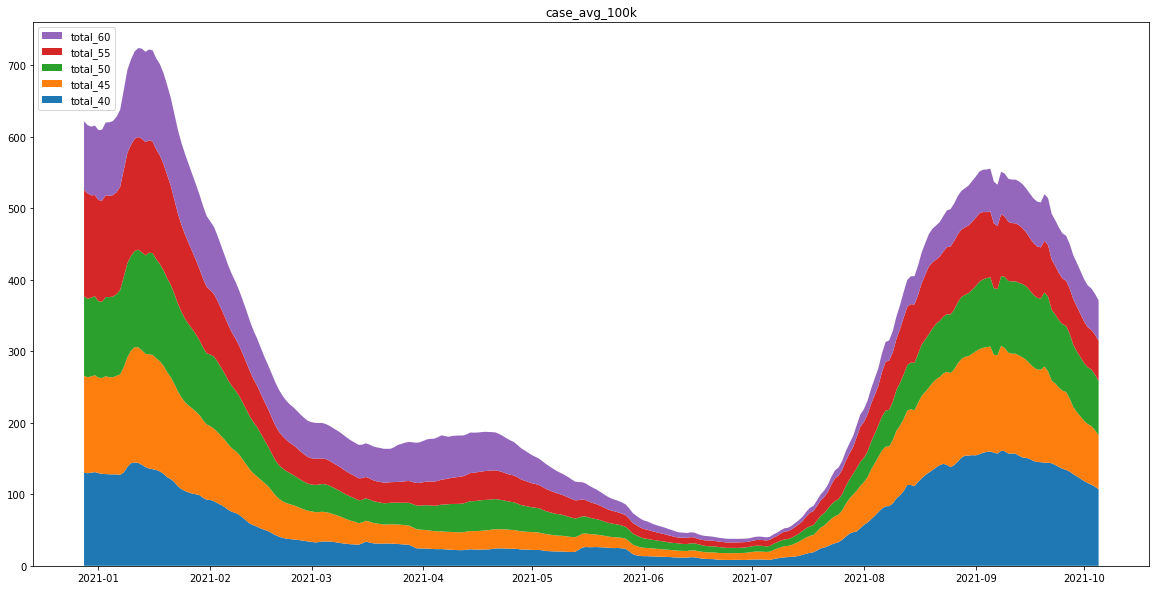

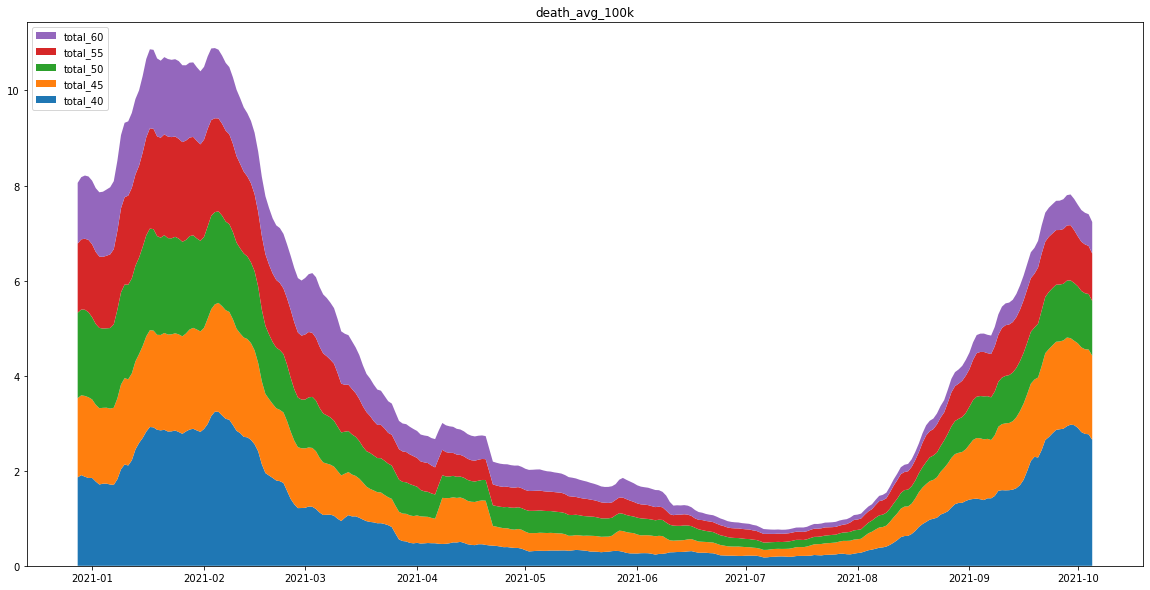

In [111]:
plot_df = geo_vax_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) ]['Name'])


vax_tier_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    vax_tier_df = pd.concat([vax_tier_df,tier_df])

vax_tier_df.dropna(inplace=True)
vax_tier_df
print(vax_tier_df)

plot_df = vax_tier_df

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_df['tier'].unique())
cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
category_col = 'tier'

for cat in cats:
    
    v1 = plot_df[plot_df[category_col] == cat]['case_avg_100k']
    #v2 = plot_df[plot_df[category_col] == cat]['total_vaccinated_percent']
    #v2=1
    #//*** Replace Infinite divide my 0 errors with 0
    plot_dict[cat] = v1


fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(20,10)

ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
             labels=plot_dict.keys(),
 #            colors=colors_palette,
            )
plt.title('case_avg_100k')
plt.legend(reversed(plt.legend().legendHandles), reversed(plot_dict.keys()),loc='upper left')
plt.show()

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
category_col = 'tier'

for cat in cats:
    
    v1 = plot_df[plot_df[category_col] == cat]['death_avg_100k']
    #v2 = plot_df[plot_df[category_col] == cat]['total_vaccinated_percent']
    #v2=1
    #//*** Replace Infinite divide my 0 errors with 0
    plot_dict[cat] =  (v1)


fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(20,10)

ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
             labels=plot_dict.keys(),
 #            colors=colors_palette,
            )
plt.title('death_avg_100k')
plt.legend(reversed(plt.legend().legendHandles), reversed(plot_dict.keys()),loc='upper left')
plt.show()

In [112]:
category_col = 'tier'
overview_dict = {}
tot_pop = vax_tier_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    loop_dict['population'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[0]['Date']
    loop_dict['date_end'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1]['Date']
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_df[vax_tier_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_df[vax_tier_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
overview_dict

{'total_40': {'population': 12799367,
  'pop_pct': 0.039062064654838906,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-05 00:00:00'),
  'confirm_period': 1122044,
  'confirm_period_100k': 8766.402275987555,
  'confirm_deaths': 20093,
  'death_period_100k': 156.98432586549006,
  'vax_complete': 5479541,
  'vax_complete_100k': 42811.031201777405,
  'vax_partial': 6487814,
  'vax_partial_100k': 50688.55358237638,
  'states': ['Alabama',
   'Idaho',
   'Mississippi',
   'North Dakota',
   'West Virginia',
   'Wyoming']},
 'total_45': {'population': 48646248,
  'pop_pct': 0.14846225478114095,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-05 00:00:00'),
  'confirm_period': 4221945,
  'confirm_period_100k': 8678.870773343095,
  'confirm_deaths': 64324,
  'death_period_100k': 132.22808057057145,
  'vax_complete': 22640221,
  'vax_complete_100k': 46540.52867551059,
  'vax_partial': 26221873,
  'vax_partial_100k': 53903.17

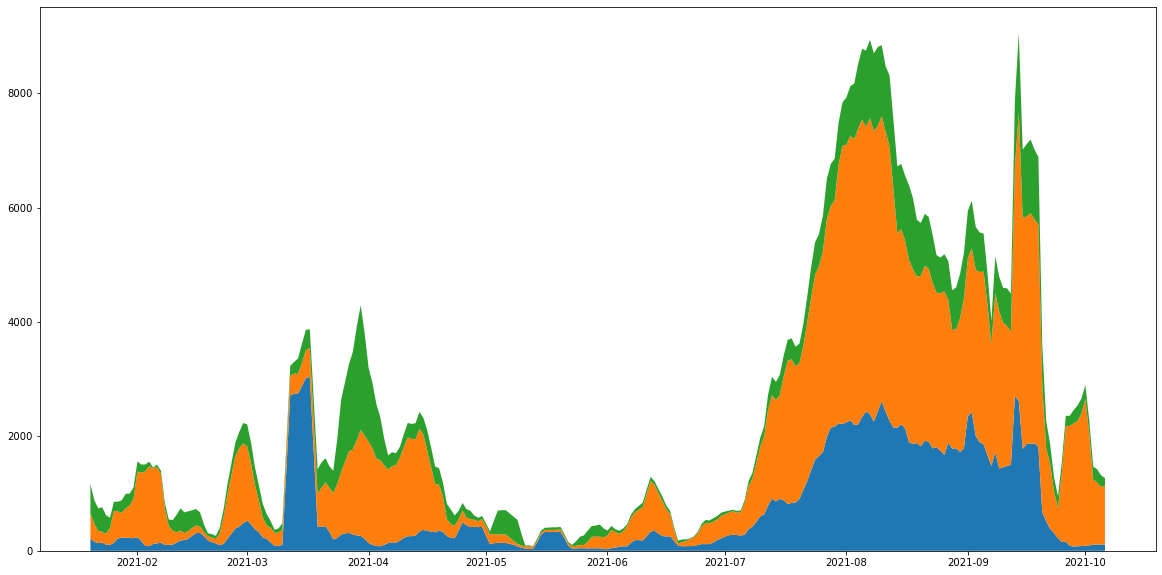

In [48]:
fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(20,10)


ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
             labels=plot_dict.keys(),
 #            colors=colors_palette,
            )
plt.show()
#plt.title("Household Expenditures: 1984-2008",fontsize=30)
#plt.legend()
#plt.legend(reversed(plt.legend().legendHandles), reversed(plot_dict.keys()),loc='upper left')
#ax.set_ylabel("Expenses ($)",fontsize=15)
#ax.tick_params(axis='both', labelsize=12)
#plt.text(0,-.1,'"Python: Stacked Area Chart"', size=pp['fontsize'], transform=ax.transAxes)

#outfilename='output_wk05_06_python_area_stacked_expenditures.png'
#out_file_for_print.append(outfilename)
#fig.savefig(outfilename)
    

In [11]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"



In [12]:
#attrib_death_df

In [13]:
#attrib_confirm_df[attrib_confirm_df.columns[:12]].iloc[:50].transpose()

#attrib_confirm_df[attrib_confirm_df['GEOID']== 40067]

In [14]:
#//*** Build Case attributes, if not using cached values
if not use_cached_files:

    #//*** Split Attribute Columns from Data Columns
    attrib_confirm_df = confirm_df[confirm_df.columns[:6]].copy()

    data_confirm_df = confirm_df[confirm_df.columns[6:]].copy()

    #//*** Move Last two Data Cols to attrib_confirm_df
    last_cols = data_confirm_df.columns[-2:]

    for col in last_cols:
        #//*** Add Column to attrib_confirm_df
        attrib_confirm_df[col] = data_confirm_df[col]

        #//*** Delete Column from data_confirm_df
        del data_confirm_df[col]


    #//*** Split Death Columns into attrib_death_df and data_death_df
    attrib_death_df = death_df[death_df.columns[:7]].copy()

    data_death_df = death_df[death_df.columns[7:]].copy()

    #//*** Move Last two Data Cols to attrib_confirm_df
    last_cols = death_df.columns[-1:]

    for col in last_cols:
        #//*** Add Column to attrib_confirm_df
        attrib_death_df[col] = data_death_df[col]

        #//*** Delete Column from data_confirm_df
        del data_death_df[col]



    #//*** Rename Attrib Columns for Cleanliness and Vanity
    ren_cols = {
        "POPESTIMATE" : "Population",
        "Combined_Key" : "Loc",
        "STNAME" : "State",
        "CTYNAME" : "County",
        #"9/17/21" : "New_Cases_9/17/21"
    }

    #//*** Get columns
    cols = np.array(attrib_confirm_df.columns)

    #//*** Replace Values
    for find_col,replace_col in ren_cols.items():
        cols = np.where(cols == find_col,replace_col,cols)

    #//*** Change Column Names    
    attrib_confirm_df.columns = cols


    #//**** clean Combined County Names
    attrib_confirm_df['Loc'] = attrib_confirm_df['Loc'].str.replace(", US","")

    #//**** Rename DEATH_DF Columns
    #//*** Get columns
    cols = np.array(attrib_death_df.columns)

    #//*** Replace Values
    for find_col,replace_col in ren_cols.items():
        cols = np.where(cols == find_col,replace_col,cols)

    #//*** Change Column Names    
    attrib_death_df.columns = cols


    #//**** clean Combined County Names
    attrib_confirm_df['Loc'] = attrib_confirm_df['Loc'].str.replace(", US","")
    attrib_death_df['Loc'] = attrib_death_df['Loc'].str.replace(", US","")


    #//*** Clean Attributes
    attrib_confirm_df

    #//**********************
    #//*** Build Daily Data
    #//**********************

    #//*** Get All Dates
    all_dates = list(data_confirm_df.columns)
    all_dates

    start_time = time.time()
    print(f"Begin Building Case Attributes...")


    #//*** Loop through each date and build daily derived Data
    for date in all_dates:

        #//*** Add New Cases for each Date
        col = f"{date}_New_Cases"
        attrib_confirm_df[col] = data_confirm_df[date].astype(int)
        
        col = f"{date}_New_Deaths"
        attrib_death_df[col]   = data_death_df[date].astype(int)

        #//*** Calculate New Cases Per 100k
        col = f"{date}_New_Cases_per_100k"
        attrib_confirm_df[col] = (data_confirm_df[date] / attrib_confirm_df['pop_100k']).astype(int)
        
        death_col = f"{date}_New_Deaths_per_100k"
        attrib_death_df[death_col] =   (data_death_df[date] / attrib_death_df['pop_100k']).astype(int)

        #//*** Build Scaled 100k cases (min=0, max=100)
        #//*** Make a copy to date_scaled_100k
        attrib_confirm_df[f"{date}_scaled_100k"] = attrib_confirm_df[col]
        attrib_death_df[f"{date}_scaled_100k"]   = attrib_death_df[death_col]


        #//*** Replace Values < 0 with 0. Negative values are due to adjustments from previous day values
        attrib_confirm_df.loc[attrib_confirm_df[f"{date}_scaled_100k"] < 0,f"{date}_scaled_100k"]=0
        attrib_death_df.loc[attrib_death_df[f"{date}_scaled_100k"] < 0,f"{date}_scaled_100k"]=0

        #//*** Replace Values < 0 with 0. Negative values are due to adjustments from previous day values
        #//*** Set Maximum community transmission to 100. This is the Max value on the CDC Scale, and it quiets this
        attrib_confirm_df.loc[attrib_confirm_df[f"{date}_scaled_100k"] > 100,f"{date}_scaled_100k"]=100
        attrib_death_df.loc[attrib_death_df[f"{date}_scaled_100k"] > 100,f"{date}_scaled_100k"]=100

    #//*** Everything to a file
    attrib_confirm_df.to_pickle(attrib_confirm_filename)
    attrib_death_df.to_pickle(attrib_death_filename)


    # Writing to sample.json
    with open(all_dates_filename, "w") as outfile:
        outfile.write(json.dumps({"all_dates" : all_dates}))

print("Done!")

Done!


<a id="build_casevax"></a> 
### Build Combined Case Death and Vaccination Data ###

In [15]:
#use_cached_files=False
if use_cached_files:
    print("Using Cached Combined Case, Death, Vaccination Data: Skip Processing")
else:
    #//**********************************************************************************
    #//*** Build combined County: Vaccination, Confirmed, Deaths table: casevax_df
    #//**********************************************************************************
    tdf = pd.read_pickle(county_vaccine_data_filename)
    tdf = tdf[['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes', 'Completeness_pct','Administered_Dose1_Recip','Administered_Dose1_Pop_Pct',]]

    #//*** Separate out the unknown County Values. We may do something with this later
    #unk_vax_df = tdf[tdf['FIPS'] == 'UNK'].copy()

    ##//*** Remove Unknowns
    tdf = tdf[tdf['FIPS'] != 'UNK']

    #//*** Convert to int for population attrib merge
    tdf['FIPS'] = tdf['FIPS'].astype(int)

    tdf['Date'] = tdf['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

    tdf = attrib_confirm_df[attrib_confirm_df.columns[:8]].merge(tdf, left_on="GEOID", right_on='FIPS').sort_values('Date',ascending=False).reset_index(drop='True')


    #//*** Convert New Cases From Columns to Rows.
    #//*** Use the GEOID to keep both Dataframes consistent
    #//*** Will build a new dataframe with these parts

    casevax_df = pd.DataFrame()
    i = 0
    #//*** For each GEOID (county)
    for group in tdf.groupby('GEOID'):
        #print(group[0],group[1]['NAME'].unique()[0])
        i+=1
        df_type = ""
        combine_df = group[1]
        for df in [attrib_death_df,attrib_confirm_df]:
            #//*** Grab attib_df county Values
            loop_df = df[df['GEOID']==group[0]] 
            #//*** Get columns with just New Cases
            cols = []
            for col in loop_df.columns:
                #//*** Handle New Cases Col
                if "New_Cases" in col and "100k" not in col:
                    cols.append(col)
                    df_type = "New_Cases"
                #//*** Handle New Deaths Col
                if "New_Deaths"  in col and "100k" not in col:
                    cols.append(col)
                    df_type = "New_Deaths"
            loop_df = loop_df[cols]

            #//*** Get just the dates from the columns
            cols = []
            for col in loop_df.columns:
                cols.append(col.split("_")[0])
            loop_df.columns = cols
            #//*** Transpose to convert columns to rows, reset_index to get a separate date column
            loop_df = loop_df.transpose().reset_index()


            #//*** reset column names
            if df_type == "New_Cases":
                loop_df.columns = ['Date','New_Cases']

            if df_type == "New_Deaths":
                loop_df.columns = ['Date','New_Deaths']


            loop_df['Date'] = loop_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))
            
            

            combine_df = combine_df.merge(loop_df,left_on="Date", right_on="Date")
            


        combine_df = combine_df.sort_values('Date')

        #//*** Generate a 7 day average
        combine_df['case_7_day_avg'] = combine_df['New_Cases'].rolling(7).mean()

        combine_df['case_100k_avg'] = combine_df['case_7_day_avg'] / combine_df['pop_100k']

        combine_df['death_7_day_avg'] = combine_df['New_Deaths'].rolling(7).mean()

        combine_df['death_100k_avg'] = combine_df['death_7_day_avg'] / combine_df['pop_100k']


        #//*** Remove unneeded Columns
        for col in ["FIPS","Recip_County","Recip_State"]:
            if col in combine_df.columns:
                del combine_df[col]

        #//*** Drop the NaN values
        combine_df = combine_df.dropna()





        #//*** Merge then add to casevax_df
        casevax_df = pd.concat([casevax_df,combine_df])

    

        if i % 100 == 0:
            print(f"Working: {i} of {len(tdf['GEOID'].unique())}")
    casevax_df = casevax_df.sort_values(by=['Date','Province_State','NAME']).reset_index(drop=True)
    
    print("Saving to File.")
    casevax_df.to_pickle(casevax_filename)
    print("Done!")
    
    #casevax_df.corr()
    #print(pearsonr(casevax_df["New_Cases"],casevax_df["case_7_day_avg"]))
    #print(pearsonr(casevax_df["Administered_Dose1_Recip"],casevax_df["case_7_day_avg"]))
    #print(pearsonr(casevax_df["Series_Complete_Yes"],casevax_df["New_Cases"]))


    #casevax_df.iloc[-30:]

Using Cached Combined Case, Death, Vaccination Data: Skip Processing


In [16]:
attrib_confirm_df[attrib_confirm_df['NAME']=="Kern"]

,STATEFP,GEOID,NAME,geometry,Province_State,Loc,Population,pop_100k,1/29/20_New_Cases,1/29/20_New_Cases_per_100k,1/29/20_scaled_100k,1/30/20_New_Cases,1/30/20_New_Cases_per_100k,1/30/20_scaled_100k,1/31/20_New_Cases,1/31/20_New_Cases_per_100k,1/31/20_scaled_100k,2/1/20_New_Cases,2/1/20_New_Cases_per_100k,2/1/20_scaled_100k,2/2/20_New_Cases,2/2/20_New_Cases_per_100k,2/2/20_scaled_100k,2/3/20_New_Cases,2/3/20_New_Cases_per_100k,2/3/20_scaled_100k,2/4/20_New_Cases,2/4/20_New_Cases_per_100k,2/4/20_scaled_100k,2/5/20_New_Cases,2/5/20_New_Cases_per_100k,2/5/20_scaled_100k,2/6/20_New_Cases,2/6/20_New_Cases_per_100k,2/6/20_scaled_100k,2/7/20_New_Cases,2/7/20_New_Cases_per_100k,2/7/20_scaled_100k,2/8/20_New_Cases,2/8/20_New_Cases_per_100k,2/8/20_scaled_100k,2/9/20_New_Cases,2/9/20_New_Cases_per_100k,2/9/20_scaled_100k,2/10/20_New_Cases,2/10/20_New_Cases_per_100k,2/10/20_scaled_100k,2/11/20_New_Cases,2/11/20_New_Cases_per_100k,2/11/20_scaled_100k,2/12/20_New_Cases,2/12/20_New_Cases_per_100k,2/12/20_scaled_100k,2/13/20_New_Cases,2/13/20_New_Cases_per_100k,2/13/20_scaled_100k,2/14/20_New_Cases,2/14/20_New_Cases_per_100k,2/14/20_scaled_100k,2/15/20_New_Cases,2/15/20_New_Cases_per_100k,2/15/20_scaled_100k,2/16/20_New_Cases,2/16/20_New_Cases_per_100k,2/16/20_scaled_100k,2/17/20_New_Cases,2/17/20_New_Cases_per_100k,2/17/20_scaled_100k,2/18/20_New_Cases,2/18/20_New_Cases_per_100k,2/18/20_scaled_100k,2/19/20_New_Cases,2/19/20_New_Cases_per_100k,2/19/20_scaled_100k,2/20/20_New_Cases,2/20/20_New_Cases_per_100k,2/20/20_scaled_100k,2/21/20_New_Cases,2/21/20_New_Cases_per_100k,2/21/20_scaled_100k,2/22/20_New_Cases,2/22/20_New_Cases_per_100k,2/22/20_scaled_100k,2/23/20_New_Cases,2/23/20_New_Cases_per_100k,2/23/20_scaled_100k,2/24/20_New_Cases,2/24/20_New_Cases_per_100k,2/24/20_scaled_100k,2/25/20_New_Cases,2/25/20_New_Cases_per_100k,2/25/20_scaled_100k,2/26/20_New_Cases,2/26/20_New_Cases_per_100k,2/26/20_scaled_100k,2/27/20_New_Cases,2/27/20_New_Cases_per_100k,2/27/20_scaled_100k,2/28/20_New_Cases,2/28/20_New_Cases_per_100k,2/28/20_scaled_100k,2/29/20_New_Cases,2/29/20_New_Cases_per_100k,2/29/20_scaled_100k,3/1/20_New_Cases,3/1/20_New_Cases_per_100k,3/1/20_scaled_100k,3/2/20_New_Cases,3/2/20_New_Cases_per_100k,3/2/20_scaled_100k,3/3/20_New_Cases,3/3/20_New_Cases_per_100k,3/3/20_scaled_100k,3/4/20_New_Cases,3/4/20_New_Cases_per_100k,3/4/20_scaled_100k,3/5/20_New_Cases,3/5/20_New_Cases_per_100k,3/5/20_scaled_100k,3/6/20_New_Cases,3/6/20_New_Cases_per_100k,3/6/20_scaled_100k,3/7/20_New_Cases,3/7/20_New_Cases_per_100k,3/7/20_scaled_100k,3/8/20_New_Cases,3/8/20_New_Cases_per_100k,3/8/20_scaled_100k,3/9/20_New_Cases,3/9/20_New_Cases_per_100k,3/9/20_scaled_100k,3/10/20_New_Cases,3/10/20_New_Cases_per_100k,3/10/20_scaled_100k,3/11/20_New_Cases,3/11/20_New_Cases_per_100k,3/11/20_scaled_100k,3/12/20_New_Cases,3/12/20_New_Cases_per_100k,3/12/20_scaled_100k,3/13/20_New_Cases,3/13/20_New_Cases_per_100k,3/13/20_scaled_100k,3/14/20_New_Cases,3/14/20_New_Cases_per_100k,3/14/20_scaled_100k,3/15/20_New_Cases,3/15/20_New_Cases_per_100k,3/15/20_scaled_100k,3/16/20_New_Cases,3/16/20_New_Cases_per_100k,3/16/20_scaled_100k,3/17/20_New_Cases,3/17/20_New_Cases_per_100k,3/17/20_scaled_100k,3/18/20_New_Cases,3/18/20_New_Cases_per_100k,3/18/20_scaled_100k,3/19/20_New_Cases,3/19/20_New_Cases_per_100k,3/19/20_scaled_100k,3/20/20_New_Cases,3/20/20_New_Cases_per_100k,3/20/20_scaled_100k,3/21/20_New_Cases,3/21/20_New_Cases_per_100k,3/21/20_scaled_100k,3/22/20_New_Cases,3/22/20_New_Cases_per_100k,3/22/20_scaled_100k,3/23/20_New_Cases,3/23/20_New_Cases_per_100k,3/23/20_scaled_100k,3/24/20_New_Cases,3/24/20_New_Cases_per_100k,3/24/20_scaled_100k,3/25/20_New_Cases,3/25/20_New_Cases_per_100k,3/25/20_scaled_100k,3/26/20_New_Cases,3/26/20_New_Cases_per_100k,3/26/20_scaled_100k,3/27/20_New_Cases,3/27/20_New_Cases_per_100k,3/27/20_scaled_100k,3/28/20_New_Cases,3/28/20_New_Cases_per_100k,3/28/20_scaled_100k,3/29/20_New_Cases,3/29/20_New_Cases_per_100k,3/29/20_scaled_100k,3/30/20_New_Cases,3/3

In [17]:
casevax_df

,STATEFP,GEOID,NAME,geometry,Province_State,Loc,Population,pop_100k,Date,Series_Complete_Pop_Pct,Series_Complete_Yes,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,New_Deaths,New_Cases,case_7_day_avg,case_100k_avg,death_7_day_avg,death_100k_avg
0,01,1001,Autauga,"POLYGON ((-86.91759 32.66417, -86.71339 32.661...",Alabama,"Autauga, Alabama",55869,0.55869,2020-12-19,0.0,0,0.0,0.0,0.0,0,62,51.571429,92.307771,0.000000,0.000000
1,01,1003,Baldwin,"POLYGON ((-88.02632 30.75336, -87.94455 30.827...",Alabama,"Baldwin, Alabama",223234,2.23234,2020-12-19,0.0,0,0.0,0.0,0.0,0,151,154.000000,68.985907,0.000000,0.000000
2,01,1005,Barbour,"POLYGON ((-85.73573 31.62449, -85.66565 31.786...",Alabama,"Barbour, Alabama",24686,0.24686,2020-12-19,0.0,0,0.0,0.0,0.0,0,8,7.142857,28.934850,0.000000,0.000000
3,01,1007,Bibb,"POLYGON ((-87.42194 33.00338, -87.31854 33.006...",Alabama,"Bibb, Alabama",22394,0.22394,2020-12-19,0.0,0,0.0,0.0,0.0,0,26,25.000000,111.637046,0.000000,0.000000
4,01,1009,Blount,"POLYGON ((-86.96336 33.85822, -86.92439 33.909...",Alabama,"Blount, Alabama",57826,0.57826,2020-12-19,0.0,0,0.0,0.0,0.0,1,63,65.000000,112.406184,0.142857,0.247047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877475,56,56037,Sweetwater,"POLYGON ((-110.05371 42.27074, -109.49676 42.2...",Wyoming,"Sweetwater, Wyoming",42343,0.42343,2021-10-06,37.2,15749,96.4,19538.0,46.1,0,25,30.857143,72.874248,0.000000,0.000000
877476,56,56039,Teton,"POLYGON ((-111.05533 44.66626, -110.66787 44.6...",Wyoming,"Teton, Wyoming",23464,0.23464,2021-10-06,79.5,18664,96.4,21026.0,89.6,0,4,7.142857,30.441771,0.000000,0.000000
877477,56,56041,Uinta,"POLYGON ((-111.04664 41.25163, -111.04660 41.3...",Wyoming,"Uinta, Wyoming",20226,0.20226,2021-10-06,40.0,8084,96.4,9482.0,46.9,0,18,17.000000,84.050232,0.000000,0.000000
877478,56,56043,Washakie,"POLYGON ((-108.55056 44.16845, -107.54120 44.1...",Wyoming,"Washakie, Wyoming",7805,0.07805,2021-10-06,35.5,2774,96.4,3084.0,39.5,0,16,17.714286,226.960739,0.000000,0.000000


2020-12-25 00:00:00


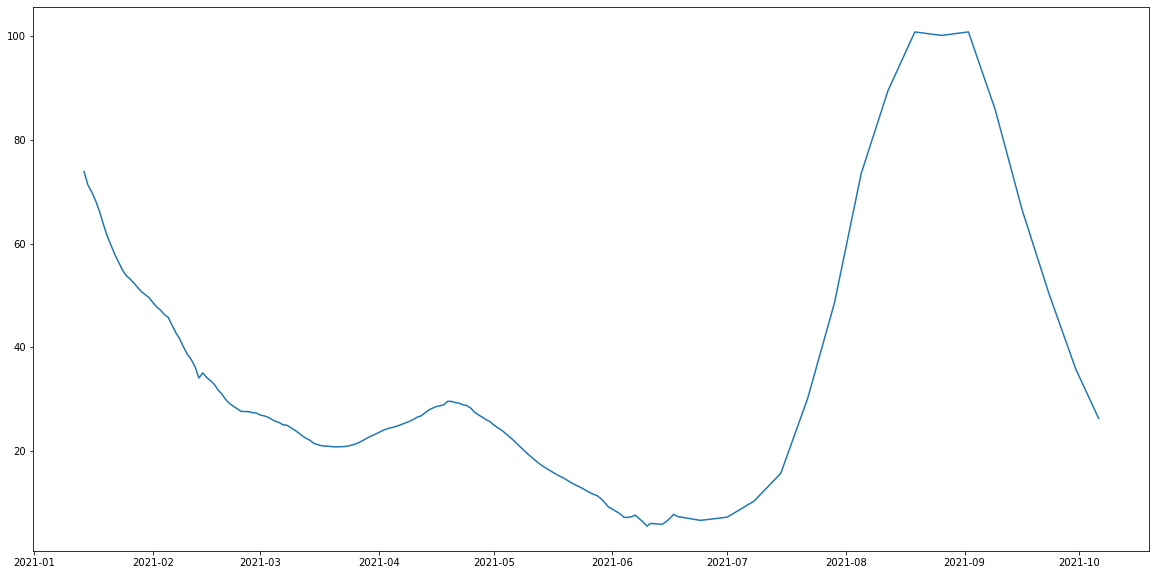

Length:  266
Date              2021-09-22 00:00:00
Complete_pct                55.614104
case_7_day_avg           11324.142857
Name: 277, dtype: object
Score: 0.6921075674904242
intercept: -113.7992838375867
slope: [58.64071392  0.75597075]


In [18]:
#Mask Mandates Ended June 15th

#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_California
#https://en.wikipedia.org/wiki/California_government_response_to_the_COVID-19_pandemic#June_2



ca_df = pd.DataFrame()

cols = ['Date','Province_State','Population','Series_Complete_Yes','Administered_Dose1_Recip','New_Cases','New_Deaths']
for group in casevax_df[casevax_df['Province_State'] == 'Florida'].sort_values("Date").groupby('Date'):
    #//*** Sum Values for Reporting Counties
    tl = [group[0],'California']
    for col in cols:
        if col == 'Date':
            continue
        if col == 'Province_State':
            continue
            
        tl.append(group[1][col].sum())
    ca_df = ca_df.append(pd.Series(tl,index=cols),ignore_index=True)
    
    
ca_df['Complete_pct'] = (ca_df['Series_Complete_Yes'] / ca_df['Population']) * 100
ca_df['Dose1_pct'] = (ca_df['Administered_Dose1_Recip'] / ca_df['Population']) * 100

ca_df['case_7_day_avg'] = ca_df['New_Cases'].rolling(7).mean()
ca_df['death_7_day_avg'] = ca_df['New_Deaths'].rolling(7).mean()

ca_df['case_100k_avg'] = ca_df['case_7_day_avg'] / (ca_df['Population'] / 100000)
ca_df['death_100k_avg'] = ca_df['death_7_day_avg'] / (ca_df['Population'] / 100000)
ca_df = ca_df.dropna()

print(ca_df['Date'].iloc[0])



loop_df = ca_df.copy()
loop_df = loop_df[loop_df['Date'] > datetime(year=2021,month=1,day=13)]
#loop_df = loop_df[loop_df['Date'] < datetime.datetime(year=2021,month=7,day=1)]


fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(20,10)


ax.plot(loop_df['Date'],loop_df['case_100k_avg']    )
#plt.title("Household Expenditures: 1984-2008",fontsize=30)
#plt.legend()
#plt.legend(reversed(plt.legend().legendHandles), reversed(plot_dict.keys()),loc='upper left')
#ax.set_ylabel("Expenses ($)",fontsize=15)
#ax.tick_params(axis='both', labelsize=12)

plt.show()

print("Length: ",len(loop_df))

#ca_df = ca_df[ca_df['Administered_Dose1_Pop_Pct'] < 20]
offset = 14
last_df = loop_df.iloc[offset*-1:]

x_fields = ['Complete_pct','case_7_day_avg']
offset_field = "case_7_day_avg"


l = list(loop_df[offset_field])[offset:]
for x in range(offset):
    l.append(np.nan)
#print(len(loop_df),len(l),(len(loop_df)-len(l)))

loop_df['offset_1st_offset'] = l
loop_df = loop_df.dropna()




model_df = loop_df
#//*** Build the X attributes using the x_column. These are separated for readability and modularity
x_model = model_df[x_fields]
y_model = model_df['offset_1st_offset']
#//*** Define the Linear Model
regr = LinearRegression(n_jobs=-1,positive=True)

#//*** Make Regression Magic
regr.fit(x_model, y_model)

print(loop_df[['Date','Complete_pct',f'{offset_field}']].iloc[-1])
print('Score:',regr.score(x_model, y_model))
print('intercept:', regr.intercept_)
print('slope:', regr.coef_)




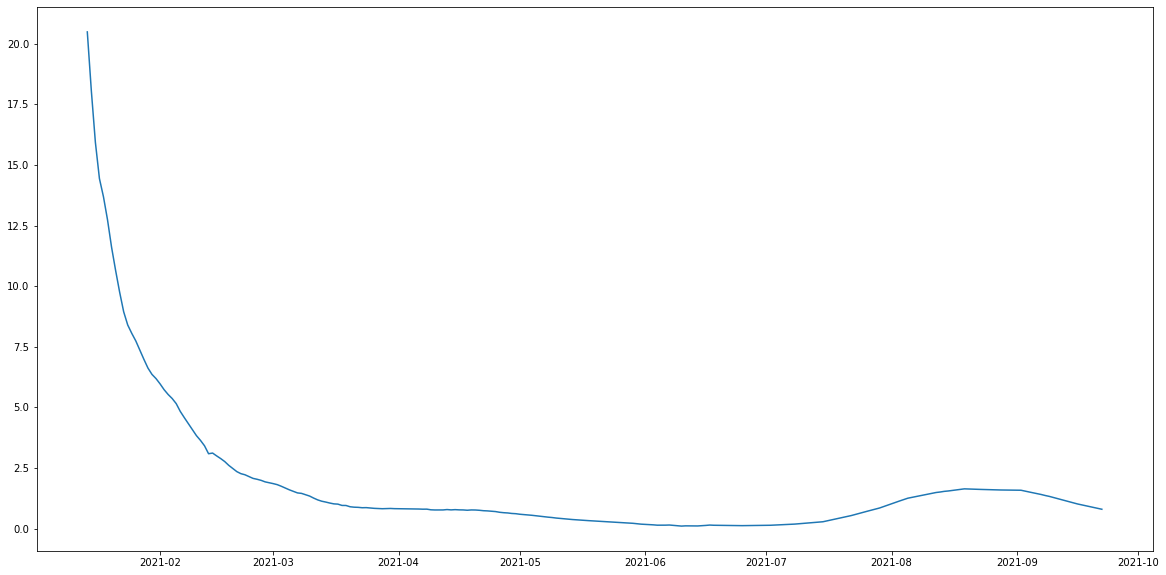

In [19]:
ca_df['Dose1_pct']/ca_df['case_100k_avg']



fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(20,10)


ax.plot(loop_df['Date'],loop_df['case_100k_avg'] / loop_df['Dose1_pct']  )
#plt.title("Household Expenditures: 1984-2008",fontsize=30)
#plt.legend()
#plt.legend(reversed(plt.legend().legendHandles), reversed(plot_dict.keys()),loc='upper left')
#ax.set_ylabel("Expenses ($)",fontsize=15)
#ax.tick_params(axis='both', labelsize=12)

plt.show()

In [20]:


#casevax_df[casevax_df['Date'] == casevax_df['Date'].unique()[-1]].sort_values("Series_Complete_Pop_Pct")

la_df = casevax_df[casevax_df['Province_State'] == 'California'].sort_values("Date")
print(la_df['Administered_Dose1_Pop_Pct'].max())
print(la_df)
#la_df = la_df[["Date","Administered_Dose1_Pop_Pct","case_7_day_avg","death_7_day_avg"]]

la_df = la_df[la_df['Administered_Dose1_Pop_Pct'] > 40]
#la_df = la_df[la_df['Administered_Dose1_Pop_Pct'] < 20]
offset = 14
last_df = la_df.iloc[offset*-1:]

#for offset in range(1,14):

l = list(la_df["case_100k_avg"])[offset:]
for x in range(offset):
    l.append(np.nan)
#print(len(la_df),len(l),(len(la_df)-len(l)))

la_df[f'offset_1st_offset'] = l
la_df = la_df.dropna()

la_df

model_df = la_df
#//*** Build the X attributes using the x_column. These are separated for readability and modularity
x_model = model_df[['Administered_Dose1_Pop_Pct']]
y_model = model_df['offset_1st_offset']
#//*** Define the Linear Model
regr = LinearRegression(n_jobs=-1,positive=True)

#//*** Make Regression Magic
regr.fit(x_model, y_model)

print(regr.score(x_model, y_model))
print('intercept:', regr.intercept_)
print('slope:', regr.coef_)

#print(regr.predict(x_model))
la_df
#geo_vax_df

99.7
       STATEFP  GEOID        NAME                                           geometry Province_State                     Loc  Population  pop_100k       Date  Series_Complete_Pop_Pct  \
157         06   6001     Alameda  POLYGON ((-122.33371 37.80980, -122.30393 37.8...     California     Alameda, California     1671329  16.71329 2020-12-19                      0.0   
188         06   6063      Plumas  POLYGON ((-121.49764 40.44559, -121.36146 40.4...     California      Plumas, California       18807   0.18807 2020-12-19                      0.0   
189         06   6065   Riverside  POLYGON ((-117.67313 33.87100, -117.65537 33.9...     California   Riverside, California     2470546  24.70546 2020-12-19                      0.0   
190         06   6067  Sacramento  POLYGON ((-121.86246 38.06603, -121.71213 38.0...     California  Sacramento, California     1552058  15.52058 2020-12-19                      0.0   
191         06   6069  San Benito  POLYGON ((-121.64400 36.89400, -121

,STATEFP,GEOID,NAME,geometry,Province_State,Loc,Population,pop_100k,Date,Series_Complete_Pop_Pct,Series_Complete_Yes,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,New_Deaths,New_Cases,case_7_day_avg,case_100k_avg,death_7_day_avg,death_100k_avg,offset_1st_offset
298334,06,6041,Marin,"POLYGON ((-123.01153 38.00344, -122.96089 38.1...",California,"Marin, California",258826,2.58826,2021-03-25,23.1,59914,96.8,105100.0,40.6,0,16,13.571429,5.243456,0.000000,0.000000,10.060070
301423,06,6041,Marin,"POLYGON ((-123.01153 38.00344, -122.96089 38.1...",California,"Marin, California",258826,2.58826,2021-03-26,24.3,62856,96.8,107063.0,41.4,0,17,14.571429,5.629816,0.000000,0.000000,5.905788
304513,06,6041,Marin,"POLYGON ((-123.01153 38.00344, -122.96089 38.1...",California,"Marin, California",258826,2.58826,2021-03-27,25.2,65141,96.8,109502.0,42.3,0,18,15.428571,5.960982,0.000000,0.000000,4.261978
307602,06,6041,Marin,"POLYGON ((-123.01153 38.00344, -122.96089 38.1...",California,"Marin, California",258826,2.58826,2021-03-28,26.1,67621,96.9,111504.0,43.1,0,16,15.714286,6.071371,0.000000,0.000000,8.002290
310691,06,6041,Marin,"POLYGON ((-123.01153 38.00344, -122.96089 38.1...",California,"Marin, California",258826,2.58826,2021-03-29,26.9,69658,96.9,113698.0,43.9,0,16,16.000000,6.181759,0.000000,0.000000,5.635265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874675,06,6007,Butte,"POLYGON ((-122.04487 39.88377, -121.80404 39.8...",California,"Butte, California",219186,2.19186,2021-10-06,45.9,100504,97.4,114299.0,52.1,0,76,87.428571,39.887845,0.714286,0.325881,8.113559
874676,06,6009,Calaveras,"POLYGON ((-120.99550 38.22540, -120.89286 38.2...",California,"Calaveras, California",45905,0.45905,2021-10-06,52.1,23938,97.4,31935.0,69.6,0,18,16.857143,36.721801,0.000000,0.000000,36.888033
874677,06,6011,Colusa,"POLYGON ((-122.78509 39.38297, -122.73906 39.3...",California,"Colusa, California",21547,0.21547,2021-10-06,49.9,10754,97.4,12494.0,58.0,0,4,3.857143,17.901067,0.000000,0.000000,39.408157
874678,06,6013,Contra Costa,"POLYGON ((-122.42526 37.95567, -122.36758 37.9...",California,"Contra Costa, California",1153526,11.53526,2021-10-06,69.6,803221,97.4,872208.0,75.6,1,149,149.285714,12.941686,0.857143,0.074306,30.666020


In [21]:
import numpy as np
from sklearn.linear_model import LinearRegression
model_df = la_df
#//*** Build the X attributes using the x_column. These are separated for readability and modularity
x_model = model_df[['Administered_Dose1_Pop_Pct','case_100k_avg']]
y_model = model_df['offset_1st_offset']
#//*** Define the Linear Model
regr = LinearRegression(n_jobs=-1,positive=True)

#//*** Make Regression Magic
regr.fit(x_model, y_model)

print(regr.score(x_model, y_model))
print('intercept:', regr.intercept_)
print('slope:', regr.coef_)

#print(regr.predict(x_model))
regr.get_params()

0.4974266421170681
intercept: -22.228182251757683
slope: [0.50731949 0.63795298]


{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': -1,
 'normalize': False,
 'positive': True}

In [22]:
"""
race_columns = (pop_attrib_df[['county',race]].sort_values(race,ascending=False)['county'])

        #print(model_df[race_columns])
        #//*** Build the X attributes using the x_column. These are separated for readability and modularity
        x_model = model_df[race_columns]

        #print(x_model)
        #//*** Build the independent variable using the Index Column defined above as y_col_index.
        y_column = model_df.columns[y_col_index]

        #//*** Build the Y model using the y_column attribute. This is less readable and intuitive, but it lets the columns be 
        #//*** easily assigned at the top of this section
        y_model = model_df[y_column]

        #//*** Define the Linear Model
        regr = linear_model.LinearRegression(n_jobs=-1)

        #//*** Make Regression Magic
        regr.fit(x_model, y_model)

        #//*** Apply the regression coefficients
        #//*** v1 Change: Apply coef to actual values
        model_df[race_columns] = (model_df[race_columns])*regr.coef_
        
        
        #//*** Dead End: v2 Change: Try just the coefficients 
        #model_df[race_columns] = regr.coef_



        #//*** Replace the Statewide Total Column. With the Statewide Race Totals
        model_df['total'] = model_df[race]

        #//*** Change The race column to hold the race name
        model_df[race] = race

        #//*** Rename the race (Latino, Native, etc) to 'race'
        cols = list(model_df.columns)
        cols[1] = 'race'
        model_df.columns = cols

        model_df['intercept'] = regr.intercept_
"""
print()

In [23]:
geo_vax_df

,STATEFP,GEOID,NAME,geometry,Name,Postal Code,FIPS,Date,Location,first_dose_count,first_dose_pct,total_vaccinated_count,total_vaccinated_percent,state,population,tot_death,tot_confirm,New_Cases,case_7_day_avg,case_avg_100k,New_Deaths,death_7_day_avg,death_avg_100k
296,1,1,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",Alabama,AL,1,2020-12-14,AL,0,0.0,0,0.0,Alabama,4903185,30.0,3666.571429,59.142857,123.816327,1.206213,0,0.000000,0.0
295,1,1,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",Alabama,AL,1,2020-12-15,AL,0,0.0,0,0.0,Alabama,4903185,26.0,3552.571429,0,101.020408,0.0,0,0.000000,0.0
294,1,1,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",Alabama,AL,1,2020-12-16,AL,0,0.0,0,0.0,Alabama,4903185,30.428571,3636.142857,0,87.673469,0.0,0.428571,0.061224,0.008741
293,1,1,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",Alabama,AL,1,2020-12-17,AL,0,0.0,0,0.0,Alabama,4903185,31.428571,3630.428571,77.857143,82.510204,1.587889,5.428571,0.836735,0.110715
292,1,1,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",Alabama,AL,1,2020-12-18,AL,0,0.0,0,0.0,Alabama,4903185,30.0,3844.0,207.857143,87.367347,4.239227,0,0.836735,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,56,56,Wyoming,"POLYGON ((-111.05689 44.86666, -111.04432 45.0...",Wyoming,WY,56,2021-10-02,WY,280930,48.5,241019,41.6,Wyoming,578759,5.857143,471.857143,7.428571,1.061224,1.283534,0.0,0.163265,0.0
3,56,56,Wyoming,"POLYGON ((-111.05689 44.86666, -111.04432 45.0...",Wyoming,WY,56,2021-10-03,WY,281039,48.6,241092,41.7,Wyoming,578759,5.857143,471.857143,0.0,1.061224,0.0,0.0,0.163265,0.0
2,56,56,Wyoming,"POLYGON ((-111.05689 44.86666, -111.04432 45.0...",Wyoming,WY,56,2021-10-04,WY,281079,48.6,241117,41.7,Wyoming,578759,5.857143,434.857143,0,1.061224,0.0,0.0,0.163265,0.0
1,56,56,Wyoming,"POLYGON ((-111.05689 44.86666, -111.04432 45.0...",Wyoming,WY,56,2021-10-05,WY,282983,48.9,243192,42.0,Wyoming,578759,6.428571,426.428571,0,1.061224,0.0,0.571429,0.163265,0.098733


In [24]:

#//********************************************
#//*** Build Current Vaccine Stats
#//********************************************

plot_df = geo_vax_df[geo_vax_df['Date'] == geo_vax_df['Date'].max()]

ren_cols = {
    "total_vaccinated_percent" : "Fully Vaccinated %",
    "first_dose_pct" : "Partially Vaccinated %"
}

cols = plot_df.columns
for find_col,replace_col in ren_cols.items():
    cols = np.where(cols == find_col,replace_col,cols)
plot_df.columns = cols

    
category = "Fully Vaccinated %"

hover_cols = (["Name","Fully Vaccinated %","Partially Vaccinated %"] )
#hover_cols = ["Loc","Population"]
out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x, med_figsize_y),
    category=category,
    title = f"Current COVID Vaccinations\nUpdated: {all_dates[-1]}",
    #category="New_Cases_9/17/21",
    simplify_shapes=50,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    #colormap="Blues",
    colormap="Cividis",
    hovertool_columns=hover_cols,
    toolbar_location=None,
    show_figure=True,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )

out_plot['vaccine_us_current'] = out_html

In [25]:
from bokeh.models import ColumnDataSource
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
plot_df = vax_df[-30:].copy()
plot_df['Series_Complete_Yes'] = plot_df['Series_Complete_Yes'] / 1000000
plot_df['Administered_Dose1_Recip'] = plot_df['Administered_Dose1_Recip'] / 1000000
plot_df['datelabel'] = plot_df['Date'].dt.strftime("%m/%d")

#plot_df['Series_Complete_Pop_Pct'] = plot_df['Series_Complete_Pop_Pct'].astype(str) + "%"
#plot_df['range']= np.arange(len(plot_df))

ren_cols = {
    "Series_Complete_Pop_Pct" : "Fully_Vaccinated",
    "Administered_Dose1_Pop_Pct" : "Partially_Vaccinated",
    "Series_Complete_Yes" : "Vaccinated",
    "Administered_Dose1_Recip" : "First_Dose",
}

cols = plot_df.columns
for find_col,replace_col in ren_cols.items():
    cols = np.where(cols == find_col,replace_col,cols)
plot_df.columns = cols

plot_df = ColumnDataSource(plot_df)

# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           title="U.S. Fully Vaccinated (30-Day)",
           toolbar_location=None,
           tools='hover',
           tooltips ="@datelabel @Vaccinated(m)"
          )
p.line(y='Fully_Vaccinated',x='Date',source=plot_df,legend_label="Fully Vaccinated")
p.scatter(y='Fully_Vaccinated',x='Date',source=plot_df)
p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "%"
p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['vax_full_30day'] = f"{div}\n {script}"
 
# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           title="Partially_Vaccinated (30-Day)",
           toolbar_location=None,
           tools='hover',
           tooltips ="@datelabel @Vaccinated(m)"
          )
p.line(y='Partially_Vaccinated',x='Date',color='orange',source=plot_df,legend_label="First Dose")
p.scatter(y='Partially_Vaccinated',x='Date',source=plot_df,color='orange')
p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "%"
p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['vax_partial_30day'] = f"{div}\n {script}"




In [26]:
death_df = pd.read_csv(death_data_filename)

death_df

death_df['Province_State'].unique()
death_df = death_df[death_df['iso2'] =='US']
death_df = death_df[death_df['Province_State'] != "Diamond Princess"]
death_df = death_df[death_df['Province_State'] != "Grand Princess"]


cols = []

cols.append(death_df.columns[6])
cols.append(death_df.columns[11])
cols = cols+list(death_df.columns[-37:])

death_state_df = pd.DataFrame(columns=cols)

for group in death_df.groupby("Province_State"):
    
   
    tds = group[1][ cols ].sum()
    tds['Province_State'] = group[0]
    #death_state_df=pd.concat([death_state_df,tds],axis=1)
    death_state_df.loc[len(death_state_df.index)] = tds
    
#death_state_df = death_state_df.transpose().reset_index(drop=True)

#death_state_df = death_state_df[ [death_state_df.columns[0]] + list(death_state_df.columns[-30:]) ] 

#//*** Generate New Deaths per Day 7-day average
death_state_df[death_state_df.columns[2:]] = death_state_df[death_state_df.columns[2:]].astype(int).diff(axis = 1, periods = 1)
death_state_df[death_state_df.columns[2:]] = death_state_df[death_state_df.columns[2:]].rolling(7,axis=1).mean()


pop100k = death_state_df['Population'] / 1000000

#for col in death_state_df[death_state_df.columns[2:]]:
#    death_state_df[col] = death_state_df[col] / pop100k

death_state_df = death_state_df.dropna(axis=1)

for col in death_state_df[death_state_df.columns[2:]]:
    death_state_df[col] = death_state_df[col].astype(str)
    death_state_df[col] = death_state_df[col].apply(lambda x : x[:4])
    death_state_df[col] = death_state_df[col].astype(float)

#death_state_df = death_state_df.sort_values(death_state_df.columns[-1],ascending=False)
total_us_deaths = death_state_df[death_state_df.columns[2:]].sum()
#plot_df = death_state_df.iloc[:10].reset_index(drop=True)
#plot_df

death_state_df
plot_df = death_state_df[death_state_df.columns[:2]].copy()
plot_df[death_state_df.columns[-1]] = death_state_df[death_state_df.columns[-1]]
plot_df.columns = ["State","Population","100k"]
plot_df["100k"] = plot_df["100k"] / pop100k
plot_df["100k"] = plot_df["100k"].apply(np.floor)
plot_df = plot_df.sort_values("100k",ascending=True)

date = death_state_df.columns[-1]
#print(plot_df)
#plot_df = ColumnDataSource(plot_df)

#[['Province_State',confirm_state_new_df.columns[-1]]]
labels = list(plot_df['State'])
# create a new plot (with a title) using figure
p = figure(plot_width=int(med_figsize_x*.8), 
           plot_height=med_figsize_y*2,
           y_range=labels,
           title=f"Statewide New Deaths (per 100k) 7 - Day Avg\nUpdated: {date}",
           toolbar_location=None,
           #tools='hover',
           #tooltips =[
           #     ("index", "$index"),
           #    ( "100k",  "@{9/21/21}{%0.2f}" ) ]
          )
#(y='Province_State',x=,source=plot_df,legend_label="Fully Vaccinated")
p.hbar(y=labels, right=list(plot_df[plot_df.columns[-1]]), left=0, height=0.5, fill_color="#b3de69")
#p.add_glyph(plot_df, glyph)

#p.scatter(y='Fully_Vaccinated',x='Date',source=plot_df)
#p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.xaxis.axis_label = "New Deaths / 100k"
#p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['states_highests_new_deaths'] = f"{div}\n {script}"

In [27]:
plot_df

,State,Population,100k
35,Ohio,11689100,0
27,Nebraska,1934408,0
39,Rhode Island,1059361,1
6,Connecticut,3565287,1
32,New York,19453561,1
8,District of Columbia,705749,1
29,New Hampshire,1359711,1
44,Utah,3205958,2
16,Kansas,2913314,2
23,Minnesota,5639632,2


In [28]:
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6

plot_df = pd.DataFrame()
plot_df['DateString'] = total_us_deaths.index
plot_df['Date'] = plot_df['DateString'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))
plot_df['Deaths'] = total_us_deaths.values
plot_df['index'] = np.arange(len(total_us_deaths))
plot_df = ColumnDataSource(plot_df)


x = np.arange(len(total_us_deaths))
# create a new plot
p = figure(plot_width=med_figsize_x, 
           plot_height=med_figsize_y, 
           title="U.S. New Deaths Per Day (7-Day Avg)",
           toolbar_location=None,
           tools='hover',
           tooltips =[    
               ( "Date",  "@DateString" ),
               ("Value", "$y{0} / Day"),
           ]
          )


#print(thisRow)
p.line(x="Date", y="Deaths", source=plot_df, alpha=0.8, color='black', line_width=2)
p.circle(x="Date", y="Deaths", source=plot_df, size=10, color='red',alpha=0.5)

p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "Daily Deaths"
#p.legend.location = "bottom_right"

show(p)

script, div = components(p)
out_plot['us_new_deaths'] = f"{div}\n {script}"

In [29]:
death_state_df

,Province_State,Population,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,9/13/21,9/14/21,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21,9/24/21,9/25/21,9/26/21,9/27/21,9/28/21,9/29/21,9/30/21,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21
0,Alabama,4903185,19.50,28.10,31.70,30.10,37.00,37.20,37.40,42.50,42.20,43.40,63.20,76.50,76.20,76.00,106.00,125.00,134.00,124.00,116.00,116.00,116.00,99.20,76.40,71.50,67.40,63.80,64.00,63.70,55.20,58.80
1,Alaska,740995,0.85,1.14,1.14,1.42,1.42,1.42,1.57,2.28,1.71,1.71,1.57,1.57,1.57,2.14,2.00,1.85,2.85,9.00,9.00,9.00,11.20,11.80,12.20,12.70,6.57,6.57,6.57,3.71,2.71,2.57
2,Arizona,7278717,38.10,32.20,37.40,26.80,26.50,27.00,26.80,35.80,36.20,31.20,33.10,43.40,46.50,46.50,40.00,46.40,52.40,51.10,45.50,42.70,42.70,48.00,43.00,36.70,43.10,46.80,46.40,46.40,41.50,41.50
3,Arkansas,3017804,24.80,24.70,23.70,25.20,27.70,30.00,32.50,32.20,31.40,32.20,30.40,28.80,25.40,26.20,23.50,23.70,21.80,21.20,20.10,20.70,21.10,21.70,20.20,20.40,22.40,21.20,21.40,17.40,17.70,15.80
4,California,39512223,95.50,88.10,87.20,96.80,97.00,90.20,104.00,108.00,119.00,125.00,115.00,117.00,123.00,114.00,113.00,108.00,102.00,110.00,101.00,91.00,107.00,105.00,106.00,106.00,95.00,92.50,92.50,96.10,93.80,96.20
5,Colorado,5758736,12.00,13.00,12.00,11.40,11.40,11.40,11.00,13.40,14.80,13.50,14.20,14.20,14.20,14.70,15.40,13.50,15.20,14.00,14.00,14.00,14.00,13.40,14.20,12.40,17.40,17.40,17.40,17.50,17.20,17.70
6,Connecticut,3565287,5.28,8.14,3.14,4.28,4.28,4.28,4.28,7.28,4.57,4.42,5.57,5.57,5.57,5.42,4.42,5.28,5.14,5.42,5.42,5.42,18.70,21.20,20.70,20.80,21.20,21.20,21.20,8.14,5.71,5.42
7,Delaware,973764,1.57,1.00,1.71,1.71,1.28,1.28,1.28,1.57,2.42,1.85,1.85,2.85,2.85,2.85,3.57,2.57,4.14,4.14,3.14,3.14,3.14,3.28,3.42,1.71,1.71,4.28,4.28,4.28,3.57,3.42
8,District of Columbia,705749,0.42,0.28,0.42,0.42,0.42,0.42,0.42,0.57,0.57,0.42,0.28,0.28,0.28,0.71,0.57,0.57,0.71,0.71,0.71,0.71,0.57,0.42,0.42,0.28,0.57,0.57,0.57,0.57,0.71,0.85
9,Florida,21477737,344.00,343.00,337.00,349.00,349.00,349.00,418.00,325.00,325.00,362.00,352.00,352.00,352.00,376.00,376.00,376.00,327.00,334.00,334.00,334.00,311.00,311.00,311.00,272.00,245.00,245.00,245.00,222.00,222.00,222.00


In [30]:
plot_df


ColumnDataSource(id='1648', ...)

In [31]:
#//*** Build State Totals
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df[confirm_df['iso2'] =='US']
confirm_df = confirm_df[confirm_df['Province_State'] != "Diamond Princess"]
confirm_df = confirm_df[confirm_df['Province_State'] != "Grand Princess"]


#state_df = pd.DataFrame(columns=(['Province_State'] + list(confirm_df.columns[11:])))

confirm_state_total_df = pd.DataFrame()

for group in confirm_df.groupby("Province_State"):
    
   
    tds = group[1][ ( [group[1].columns[6]] + list(group[1].columns[11:])) ].sum()
    tds['Province_State'] = group[0]
    confirm_state_total_df=pd.concat([confirm_state_total_df,tds],axis=1)

confirm_state_total_df = confirm_state_total_df.transpose().reset_index(drop=True)

confirm_state_total_df = confirm_state_total_df[ [confirm_state_total_df.columns[0]] + list(confirm_state_total_df.columns[-30:]) ]



confirm_state_total_df['Population'] = death_state_df['Population']
cols = list(confirm_state_total_df.columns)
cols.insert(1,cols[-1])
cols = cols[:-1]
confirm_state_total_df = confirm_state_total_df[cols]
confirm_state_new_df = confirm_state_total_df.copy()

#confirm_df[confirm_df.columns[6:]].diff(axis = 1, periods = 1)
confirm_state_new_df[confirm_state_new_df.columns[2:]] = confirm_state_new_df[confirm_state_new_df.columns[2:]].astype(int).diff(axis = 1, periods = 1)
confirm_state_new_df[confirm_state_new_df.columns[2:]] = confirm_state_new_df[confirm_state_new_df.columns[2:]].rolling(7,axis=1).mean()
                    

confirm_state_new_df = confirm_state_new_df.dropna(axis=1)
pop100k = confirm_state_new_df['Population']/100000




confirm_state_total_df[confirm_state_total_df.columns[2:]] = confirm_state_total_df[confirm_state_total_df.columns[2:]].astype(int).rolling(7,axis=1).mean()
confirm_state_total_df = confirm_state_total_df.dropna(axis=1)

for col in confirm_state_new_df.columns[2:]:
    confirm_state_new_df[col] = confirm_state_new_df[col]/pop100k
    confirm_state_new_df[col] = confirm_state_new_df[col].astype(int)
    #confirm_state_total_df[col+"%"] = confirm_state_total_df[col]/pop100k
    #confirm_state_total_df[col+"%"] = confirm_state_total_df[col].astype(int)
    #confirm_state_total_df[col+"%"] = (confirm_state_total_df[col]/1000).round(2)
    
    

from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot
plot_df=confirm_state_new_df.sort_values(confirm_state_new_df.columns[-1],ascending=True).iloc[:10]
#print(plot_df)
#plot_df = ColumnDataSource(plot_df)
col = plot_df.columns[-1]
print(col)
#[['Province_State',confirm_state_new_df.columns[-1]]]
labels = list(plot_df['Province_State'])
# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           y_range=labels,
           title="Statewide New Cases (per 100k) 7 - Day Avg",
           toolbar_location=None,
           #tools='hover',
           #tooltips =[
           #     ("index", "$index"),
           #    ( "100k",  "@{9/21/21}{%0.2f}" ) ]
          )
#(y='Province_State',x=,source=plot_df,legend_label="Fully Vaccinated")
p.hbar(y=labels, right=list(plot_df[plot_df.columns[-1]]), left=0, height=0.5, fill_color="#b3de69")
#p.add_glyph(plot_df, glyph)

#p.scatter(y='Fully_Vaccinated',x='Date',source=plot_df)
#p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.xaxis.axis_label = "New Cases / 100k"
#p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['states_highests_new_cases'] = f"{div}\n {script}"

#confirm_state_total_df.sort_values(confirm_state_total_df.columns[-1],ascending=False).iloc[:10]

10/6/21


In [32]:
confirm_state_total_df=confirm_state_total_df.sort_values(confirm_state_total_df.columns[-1],ascending=False)
plot_df = confirm_state_total_df[['Province_State','Population']].copy()
#plot_df[confirm_state_total_df.columns[-2]] = confirm_state_total_df[confirm_state_total_df.columns[-2]]
plot_df[confirm_state_total_df.columns[-1]] = confirm_state_total_df[confirm_state_total_df.columns[-1]]

#cur_date = confirm_state_total_df.columns[-2]
cur_date = confirm_state_total_df.columns[-1]
plot_df.columns = ['State','Population','Confirmed']
plot_df['%'] = ((plot_df['Confirmed'] / plot_df['Population']) * 100)
plot_df = plot_df.sort_values("%",ascending=False)

plot_df['%'] = plot_df['%'].astype(str)
plot_df['%'] = plot_df['%'].apply(lambda x: x[:5])
plot_df['%'] = plot_df['%'] + "%"


plot_df['Confirmed'] = plot_df['Confirmed'].astype(int).apply(lambda x: "{:,}".format(x))

#plot_df['Confirmed']=  plot_df['Confirmed']
plot_df['Population'] = plot_df['Population'].apply(lambda x: "{:,}".format(x))

plot_df = plot_df.reset_index(drop='True')
plot_df = plot_df.reset_index()
plot_df.columns = ['Rank','State','Population','Confirmed',"%"]
plot_df['Rank'] = plot_df['Rank'] + 1 

out_html = ""
out_html+="<table id='total_confirmed_percent'>"
out_html+="<thead>"
for col in plot_df.columns:
    out_html += f"<td>{col}</td>"

out_html+="</thead>"

for row in plot_df.iterrows():
    out_html+="<tr>"
    for val in row[1]:
        out_html+=f"<td>{val}</td>"
    out_html+="</tr>"
out_html+="</table>"


out_plot['total_confirmed_percent'] = out_html
#print(out_html)
plot_df.iloc[:10]

,Rank,State,Population,Confirmed,%
0,1,Tennessee,"6,829,174","1,235,367",18.08%
1,2,North Dakota,"762,062","133,854",17.56%
2,3,Florida,"21,477,737","3,614,777",16.83%
3,4,South Carolina,"5,148,714","863,460",16.77%
4,5,Arkansas,"3,017,804","497,970",16.50%
5,6,South Dakota,"884,659","145,838",16.48%
6,7,Mississippi,"2,976,149","490,157",16.46%
7,8,Rhode Island,"1,059,361","173,059",16.33%
8,9,Alabama,"4,903,185","800,563",16.32%
9,10,Louisiana,"4,648,794","742,872",15.97%


In [33]:

#//*** Build and Plot US Total Confirm Cases and Rolling 7-day
confirm_df = pd.read_csv(confirmed_data_filename)

usa_df = pd.DataFrame(index=['total','7day_avg'],data=[confirm_df[confirm_df.columns[11:]].sum(),confirm_df[confirm_df.columns[11:]].rolling(7).mean().sum()] )

usa_df = usa_df.dropna(axis=1).transpose()
usa_df['7day_avg'] = usa_df['7day_avg'].astype(int)/1000000
usa_df['total'] = usa_df['total'].astype(int)/1000000
usa_df['total'] = usa_df['total'].round(1)
usa_df['Date'] =usa_df.index
usa_df['DateLabel'] =usa_df.index

#//*** Convert date string to datetime
usa_df['Date'] = usa_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))

plot_df = usa_df[-30:]
plot_df


plot_df = ColumnDataSource(plot_df)

# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           title="US Confirmed Cases",
           toolbar_location=None,
           tools='hover',
           tooltips ="@total(m)"
          )
p.line(x='Date',y='total',source=plot_df,legend_label="Total Confirmed Cases")
p.scatter(y='total',x='Date',source=plot_df)
#p.line(x='Date',y='7day_avg',source=plot_df,legend_label="7 Day Average")
p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "(millions)"
p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['us_confirmed_cases'] = f"{div}\n {script}"

In [34]:


#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
plot_df = attrib_confirm_df.copy()
    

slider_columns = [f"{x}_scaled_100k" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
out_plot['confirm_historical'] = out_html

In [35]:
attrib_confirm_df[(list(attrib_confirm_df.columns[:8]) + list(attrib_confirm_df.columns[-3:]))]

,STATEFP,GEOID,NAME,geometry,Province_State,Loc,Population,pop_100k,10/6/21_New_Cases,10/6/21_New_Cases_per_100k,10/6/21_scaled_100k
0,37,37017,Bladen,"POLYGON ((-78.90200 34.83527, -78.79960 34.850...",North Carolina,"Bladen, North Carolina",32722,0.32722,10,30,30
1,37,37167,Stanly,"POLYGON ((-80.49737 35.20210, -80.29542 35.502...",North Carolina,"Stanly, North Carolina",62806,0.62806,29,47,47
2,39,39153,Summit,"POLYGON ((-81.68699 41.13596, -81.68495 41.277...",Ohio,"Summit, Ohio",541013,5.41013,193,35,35
3,42,42113,Sullivan,"POLYGON ((-76.81373 41.59003, -76.22014 41.541...",Pennsylvania,"Sullivan, Pennsylvania",6066,0.06066,1,21,21
4,48,48459,Upshur,"POLYGON ((-95.15274 32.66095, -95.15211 32.902...",Texas,"Upshur, Texas",41753,0.41753,15,37,37
...,...,...,...,...,...,...,...,...,...,...,...
3137,22,22003,Allen,"POLYGON ((-93.13029 30.59789, -92.97917 30.598...",Louisiana,"Allen, Louisiana",25627,0.25627,7,27,27
3138,38,38005,Benson,"POLYGON ((-99.84661 48.37130, -99.49292 48.370...",North Dakota,"Benson, North Dakota",6832,0.06832,1,16,16
3139,31,31159,Seward,"POLYGON ((-97.36812 41.04695, -96.91094 41.046...",Nebraska,"Seward, Nebraska",17284,0.17284,2,13,13
3140,37,37023,Burke,"POLYGON ((-81.90665 35.88338, -81.94319 35.960...",North Carolina,"Burke, North Carolina",90485,0.90485,59,65,65


In [36]:
#//********************************************
#//*** Build Confirmed Current Stats Plot
#//********************************************
plot_df = attrib_confirm_df[(list(attrib_confirm_df.columns[:8]) + list(attrib_confirm_df.columns[-3:]))].copy()

category = plot_df.columns[-1]

hover_cols = (["Loc","Population"] + list(plot_df.columns[-3:-1]))
#hover_cols = ["Loc","Population"]
out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x, med_figsize_y),
    category=category,
    title = f"Current COVID New Case Prevalence (per 100k population) 7-Day Average\nUpdated: {all_dates[-1]}",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    toolbar_location=None,
    hovertool_columns=hover_cols,
    show_figure=True,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
out_plot['confirm_latest'] = out_html

In [37]:
plot_df

,STATEFP,GEOID,NAME,geometry,Province_State,Loc,Population,pop_100k,10/6/21_New_Cases,10/6/21_New_Cases_per_100k,10/6/21_scaled_100k
0,37,37017,Bladen,"POLYGON ((-78.90200 34.83527, -78.79960 34.850...",North Carolina,"Bladen, North Carolina",32722,0.32722,10,30,30
1,37,37167,Stanly,"POLYGON ((-80.49737 35.20210, -80.29542 35.502...",North Carolina,"Stanly, North Carolina",62806,0.62806,29,47,47
2,39,39153,Summit,"POLYGON ((-81.68699 41.13596, -81.68495 41.277...",Ohio,"Summit, Ohio",541013,5.41013,193,35,35
3,42,42113,Sullivan,"POLYGON ((-76.81373 41.59003, -76.22014 41.541...",Pennsylvania,"Sullivan, Pennsylvania",6066,0.06066,1,21,21
4,48,48459,Upshur,"POLYGON ((-95.15274 32.66095, -95.15211 32.902...",Texas,"Upshur, Texas",41753,0.41753,15,37,37
...,...,...,...,...,...,...,...,...,...,...,...
3137,22,22003,Allen,"POLYGON ((-93.13029 30.59789, -92.97917 30.598...",Louisiana,"Allen, Louisiana",25627,0.25627,7,27,27
3138,38,38005,Benson,"POLYGON ((-99.84661 48.37130, -99.49292 48.370...",North Dakota,"Benson, North Dakota",6832,0.06832,1,16,16
3139,31,31159,Seward,"POLYGON ((-97.36812 41.04695, -96.91094 41.046...",Nebraska,"Seward, Nebraska",17284,0.17284,2,13,13
3140,37,37023,Burke,"POLYGON ((-81.90665 35.88338, -81.94319 35.960...",North Carolina,"Burke, North Carolina",90485,0.90485,59,65,65


In [38]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False

#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if not use_cached_files:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/base_gif_1/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=20

    dates = all_dates[100:]
    #dates = all_dates[-30:]

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:

        file_counter += 1

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                print(f"Skipping: {save_filename}")
                
                #//*** Read Files and Prepare Animated GID
                if first == True:
                    first=False
                    first_img = Image.open(save_filename)
                else:
                    gif_files.append(Image.open(save_filename))
                continue
                
                
        fig, ax = plt.subplots()

        fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.8,edgecolor='.8')
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        plt.viridis()

        
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()

        #//*** Read Files and Prepare Animated GID
        if first == True:
            first=False
            first_img = Image.open(save_filename)
        else:
            gif_files.append(Image.open(save_filename))
    
    print("Building GIF...")
    #//*** Build and Save Animated GIF
    first_img.save("confirm_100k_history.gif", save_all=True, optimize=True, append_images=gif_files, duration=50, loop=0)

    out_images.append("confirm_100k_history.gif")


    print("Done...")

In [39]:
#//********************************************
#//*** Build Deaths Current Stats Plot
#//********************************************
plot_df = attrib_death_df[(list(attrib_death_df.columns[:8]) + list(attrib_death_df.columns[-3:]))].copy()



category = plot_df.columns[-1]

#//*** Assign Max Scale Value 5
plot_df.loc[plot_df[category] > 5,category]=5

hover_cols = ["Loc","Population"]
hover_cols = (["Loc","Population"] + list(plot_df.columns[-3:-1]))

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x, med_figsize_y),
    category=category,
    title = f"Current COVID New Death Prevalence (per 100k population) 7-Day Average\nUpdated: {all_dates[-1]}",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    #colormap="Viridis",
    #colormap="Inferno",
    toolbar_location=None,
    colormap="Magma",
    hovertool_columns=hover_cols,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )

out_plot['death_latest'] = out_html

In [40]:
#//********************************************
#//*** Build Death Historical Slider Plot
#//********************************************
plot_df = attrib_death_df.copy()

#//*** Assign Max Scale Value 5
for col in [f"{x}_scaled_100k" for x in all_dates]:
    plot_df.loc[plot_df[col] > 5,col]=5

#//*** Assign Max Scale Value 100 is too much
#for col in [f"{x}_New_Deaths" for x in all_dates]:
#    plot_df.loc[plot_df[col] > 10,col]=20
#    plot_df.loc[plot_df[col] < 0,col]=0
    
    
slider_columns = [f"{x}_scaled_100k" for x in all_dates]
#slider_columns = [f"{x}_New_Deaths" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Death Prevalence (Cases per 100k Population) 7-Day Average: {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    #colormap="Viridis",
    #colormap="Inferno",
    toolbar_location=None,
    colormap="Magma",
    hovertool_columns=hover_cols,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
out_plot['death_historical'] = out_html

In [41]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL Death GIF
#//*********************************
#//*********************************

#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if not use_cached_files:
#if True:
    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/base_gif_death_1/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_death_df.copy()

    fontsize=20

    dates = all_dates[100:]
    #dates = all_dates[-30:]

    first=True
    first_img = None
    file_counter = 0
    print("Working...")
    for date in dates:

        file_counter += 1

        
        save_filename = f"{filepath}death_hist_{file_counter}.jpg"
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                print(f"Skipping: {save_filename}")
                
                #//*** Read Files and Prepare Animated GID
                if first == True:
                    first=False
                    first_img = Image.open(save_filename)
                else:
                    gif_files.append(Image.open(save_filename))
                continue
                
        fig, ax = plt.subplots()

        fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.magma(), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.8,edgecolor='.8')
        plt.title(f"COVID-19 Daily Deaths \nper 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        plt.viridis()

        
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})
        #plt.show()
        plt.close()
        
        #//*** Read Files and Prepare Animated GID
        if first == True:
            first=False
            first_img = Image.open(save_filename)
        else:
            gif_files.append(Image.open(save_filename))
    print("Building Animated GIF...")
    #//*** Build and Save Animated GIF
    first_img.save("confirm_100k_history_deaths.gif", save_all=True, optimize=True, append_images=gif_files, duration=50, loop=0)

    out_images.append("confirm_100k_history_deaths.gif")


    print("Done...")

In [42]:
#out_images.append("confirm_100k_thumb.gif")
#out_images.append("confirm_100k_history.gif")

In [43]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/vaccine_us_current.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/vax_full_30day.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/vax_partial_30day.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/states_highests_new_deaths.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/us_new_deaths.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/states_highests_new_cases.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/total_confirmed_percent.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/us_confirmed_cases.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/confirm_historical.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/confirm_latest.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/death_latest.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/dea

In [44]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)
